In [ ]:
import os
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.spatial.distance import pdist, cdist
from mpl_toolkits.mplot3d import Axes3D
import soundfile as sf
from prettytable import PrettyTable
from scipy.signal import hilbert
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.signal import hilbert, butter, filtfilt

**DICCIONARIOS CON LAS RUTAS**

In [ ]:
fruit_types = ['pera', 'banana', 'manzana', 'naranja']
fruits = {fruit: [] for fruit in fruit_types}
root_dir = '../../dataset'

for dirname, _, filenames in os.walk(root_dir):
    fruit_type = os.path.basename(dirname)
    if fruit_type in fruit_types:
        fruits[fruit_type].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

In [ ]:
trimed_audio = {fruit: [] for fruit in fruit_types}
for dirname, _, filenames in os.walk(root_dir):
    trimpath = os.path.basename(dirname)

    if trimpath in 'trimed':
        fruit_type = os.path.basename(os.path.dirname(dirname))
        if fruit_type in fruit_types:
            trimed_audio[fruit_type].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

In [ ]:
adjusted_audio = {fruit: [] for fruit in fruit_types}
for dirname, _, filenames in os.walk(root_dir):
    adjustedpath = os.path.basename(dirname)

    if adjustedpath in 'adjusted':
        fruit_type = os.path.basename(os.path.dirname(dirname))
        if fruit_type in fruit_types:
            adjusted_audio[fruit_type].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

**CARACTERISTICAS DEL AUDIO**

In [ ]:
FRAME_SIZE = 512 # In the documentation says it's convenient for speech.C
HOP_SIZE   = 256

**FUNCIONES**

In [ ]:
def load_audio(audiofile):
    test_audio, sr = librosa.load(audiofile, sr = None)
    duration = librosa.get_duration(filename=audiofile, sr=sr)
    return test_audio, sr, duration

In [ ]:
def calculate_smoothed_envelope(signal, sr, cutoff_frequency = 10.0):
    analytic_signal = hilbert(signal)

    # Calcular la envolvente de amplitud
    amplitude_envelope = np.abs(analytic_signal)

    # Aplicar filtro pasa bajos para suavizar la envolvente
    nyquist = 0.5 * sr
    cutoff = cutoff_frequency / nyquist
    b, a = butter(N=6, Wn=cutoff, btype='low', analog=False, output='ba')
    
    smoothed_envelope = filtfilt(b, a, amplitude_envelope)

    return amplitude_envelope, smoothed_envelope

In [ ]:
def get_features(n_mfcc, fruits):
    fruit_vectors = dict.fromkeys(fruits.keys())
    
    for fruit_name, group in fruits.items():
        vectors = list()
        for fruit in group:
            signal, sr, _ = load_audio(fruit)

            mfccs = librosa.feature.mfcc(y=signal, n_mfcc=n_mfcc, sr=sr)
            delta_mfccs = librosa.feature.delta(mfccs)
            delta2_mfccs = librosa.feature.delta(mfccs, order = 2)
            
            _, smoothed_envelope = calculate_smoothed_envelope(signal, sr, 45)

            selected_indices = np.linspace(0, len(smoothed_envelope) - 1, n_mfcc, dtype=int)
            smoothed_envelope = smoothed_envelope[selected_indices]
            smoothed_envelope = smoothed_envelope.reshape(-1,1)

            smoothed_envelope = smoothed_envelope /np.max(np.linalg.norm(smoothed_envelope , axis=0))
            mfccs = mfccs/np.max(np.linalg.norm(mfccs, axis=0))
            delta_mfccs  = delta_mfccs/np.max(np.linalg.norm(delta_mfccs, axis=0))
            delta2_mfccs = delta2_mfccs/np.max(np.linalg.norm(delta2_mfccs, axis=0))

            #features =  np.concatenate((delta_mfccs, smoothed_envelope), axis = 1)
            features = smoothed_envelope
            features = np.mean(features.T, axis = 0)
            vectors.append(features.reshape(1,-1))
            
        fruit_vectors[fruit_name] = np.vstack(vectors)
    return fruit_vectors

los que mas producen diferencia de forma individual son:
- el delta
- el smoothed(las componentes 4 y 5 cuando son 13 nmfccs)
- el cmoothed separa muy bien las manzanas, agrupa ien las bananas y en general anda bien
- el deltamfccs separa bien a las peras de lo demas
- Se vio que la envolvente es la que mejor resultados da, el problema es que solamente cuando el audio esta trimeado

In [ ]:
def get_sphere(vectors):
    center = np.mean(vectors, axis = 0)
    center = center.reshape(1, -1)
    radius = cdist(center, vectors).max()     # Pairwise distance
    return radius, center

In [ ]:
def get_centers(features):
    centers = dict.fromkeys(features.keys())
    for fruit, group in features.items():
        _, center = get_sphere(group)
        centers[fruit] = center
    return centers

In [ ]:
def get_radiuses(features):
    radiuses = dict.fromkeys(features.keys())
    for fruit, group in features.items():
        radius, _ = get_sphere(group)
        radiuses[fruit] = radius
    return radiuses

In [ ]:
def get_overlaps(fruit_features):
    centers = get_centers(fruit_features)
    radiuses = get_radiuses(fruit_features)
    overlaps = dict.fromkeys(fruit_features.keys())
    
    # A dictionary of dictionarys. Keys, the fruit types
    for key in overlaps:
        # Each dictionary in the dictionary
        overlaps[key] = dict.fromkeys(fruit_types)
    
    for i in range(len(fruit_types)):
        for j in range(i + 1, len(fruit_types)):
            distancesAB = cdist(centers[fruit_types[i]], fruit_features[fruit_types[j]])
            distancesBA = cdist(centers[fruit_types[j]], fruit_features[fruit_types[i]])

            mask_distancesAB = distancesAB < radiuses[fruit_types[i]]
            mask_distancesBA = distancesBA < radiuses[fruit_types[j]]

            numberBinA = np.count_nonzero(mask_distancesAB)
            numberAinB = np.count_nonzero(mask_distancesBA)

            overlaps[fruit_types[i]][fruit_types[j]] = numberBinA
            overlaps[fruit_types[j]][fruit_types[i]] = numberAinB
    return overlaps # Each element is the number of vectors of one group in the sphere of another

In [ ]:
def get_components(centers, nc):
    pacum = np.zeros((1, centers[fruit_types[0]].shape[1]))
    pair_components = dict()
    for i in range(len(fruit_types)):
        for j in range(i + 1, len(fruit_types)):
            dif = centers[fruit_types[i]] - centers[fruit_types[j]]
            dist = cdist(centers[fruit_types[i]], centers[fruit_types[j]])
            difp = (dif**2)*100/(dist**2)
            pair_components[f"{fruit_types[i]}-{fruit_types[j]}"]= np.argsort(difp[0])[-nc:]
            pacum += difp
    index_max = np.argsort(pacum[0])[-nc:]
    #return np.sort(index_max)
    return index_max, pair_components

**PRINCIPAL**

In [ ]:
features = get_features(5, trimed_audio)
overlaps = get_overlaps(features)
centers = get_centers(features)
components, _ = get_components(centers, 2) 
radius, _ = get_sphere(np.squeeze(list(centers.values()), axis=1))

print(f"componentes: {components}")

for pair, overlap in overlaps.items():
    print(f"{pair}: {overlap}")

print(f"radius: {radius}")

C:\Users\Juan\AppData\Local\Temp\ipykernel_10956\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


componentes: [1 3]
pera: {'pera': None, 'banana': 3, 'manzana': 2, 'naranja': 1}
banana: {'pera': 10, 'banana': None, 'manzana': 10, 'naranja': 10}
manzana: {'pera': 10, 'banana': 7, 'manzana': None, 'naranja': 3}
naranja: {'pera': 8, 'banana': 6, 'manzana': 6, 'naranja': None}
radius: 0.2407191455109451


In [ ]:
for name, group in features.items():
    features[name] = group[:, np.sort(components)]

In [ ]:
whole = np.concatenate(list(features.values()), axis=0)

#Paso 2: Aplicar PCA para obtener dos componentes principales
pca = PCA(n_components = 2)
reduced_features = pca.fit_transform(whole)

#Paso 3: Crear un diccionario con las matrices reducidas
reduced = {}
start_idx = 0

for fruit, matrix in features.items():
    num_rows = matrix.shape[0]
    reduced[fruit] = reduced_features[start_idx:start_idx + num_rows, :]
    start_idx += num_rows
features = reduced

**KNN**

In [ ]:
def knn(training, test, k_n):
    X = np.concatenate([v for v in training.values()], axis=0)
    y = np.concatenate([[k] * v.shape[0] for k, v in training.items()])

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Crear clasificador KNN
    knn_classifier = KNeighborsClassifier(n_neighbors = k_n)

    # Entrenar el clasificador
    knn_classifier.fit(X, y)

    # Predecir las etiquetas para los datos de prueba
    predicted_fruit = knn_classifier.predict(test)

    print(f'La fruta predicha para el nuevo audio es: {predicted_fruit[0]}')

**PLOTEO**

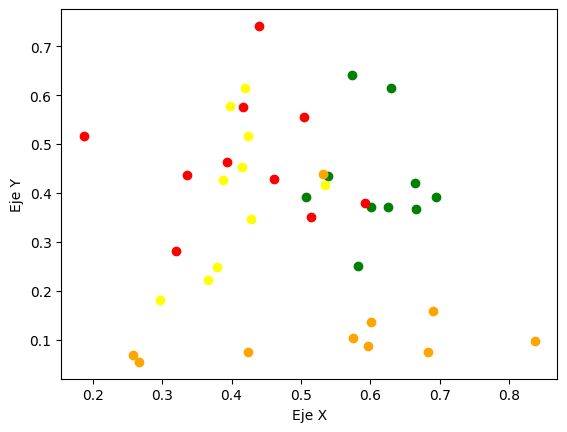

In [ ]:
#2d
fig = plt.figure()

colors = dict(zip(fruit_types,['green','yellow','red','orange']))
center_colors  = dict(zip(fruit_types,['blue','brown','black','cyan']))

for fruit, points in features.items():
    plt.scatter(points[:, 0], points[:, 1], c = colors[fruit], label=fruit)

plt.xlabel('Eje X')
plt.ylabel('Eje Y')

plt.show()

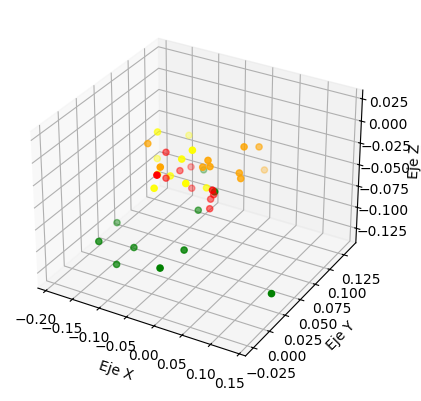

In [ ]:
#3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for fruit, points in features.items():
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors[fruit], marker='o', label=fruit)
    #ax.scatter(centers[fruit][:, 0], centers[fruit][:, 1], centers[fruit][:, 2], c=center_colors[fruit], marker='o', label=f"{fruit}-center")

# configure labels
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')
ax.set_zlabel('Eje Z')
plt.show()

**PRUEBA ENVOLVENTES**

In [ ]:
fruit = 'pera'
indice = 6


# Función para cargar la señal de audio y calcular la envolvente
def calculate_amplitude_envelope(file_path):
    # Cargar la señal de audio
    signal, sr = librosa.load(file_path, sr=None)

    # Calcular la transformada de Hilbert
    analytic_signal = hilbert(signal)

    # Calcular la envolvente de amplitud
    amplitude_envelope = np.abs(analytic_signal)

    return signal, sr, amplitude_envelope

# Ruta de tu archivo de audio
file_path = fruits[fruit][indice]

# Calcular la señal y la envolvente de amplitud
original_signal, sr, amplitude_envelope = calculate_amplitude_envelope(file_path)

# Crear el gráfico
plt.figure(figsize=(12, 6))

# Visualizar la señal original
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(original_signal)) / sr, original_signal)
plt.title('Señal Original')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')

# Visualizar la envolvente de amplitud
plt.subplot(2, 1, 2)
plt.plot(np.arange(len(amplitude_envelope)) / sr, amplitude_envelope, alpha=0.5)
plt.title('Envolvente de Amplitud')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')

# Ajustar el diseño del gráfico
plt.tight_layout()
plt.show()


In [ ]:
from scipy.signal import hilbert, butter, filtfilt

fruit = 'pera'
indice = 6

# Función para cargar la señal de audio y calcular la envolvente suavizada
def calculate_smoothed_envelope(file_path, cutoff_frequency=10.0):
    # Cargar la señal de audio
    signal, sr = librosa.load(file_path, sr=None)

    # Calcular la transformada de Hilbert
    analytic_signal = hilbert(signal)

    # Calcular la envolvente de amplitud
    amplitude_envelope = np.abs(analytic_signal)

    # Aplicar filtro pasa bajos para suavizar la envolvente
    nyquist = 0.5 * sr
    cutoff = cutoff_frequency / nyquist
    b, a = butter(N=6, Wn=cutoff, btype='low', analog=False, output='ba')
    print(f"(b, a): ({b},{a})")
    smoothed_envelope = filtfilt(b, a, amplitude_envelope)

    return signal, sr, amplitude_envelope, smoothed_envelope

# Ruta de tu archivo de audio
file_path = fruits[fruit][indice]

# Calcular la señal y las envolventes
original_signal, sr, amplitude_envelope, smoothed_envelope = calculate_smoothed_envelope(file_path, 50)

# Crear el gráfico
plt.figure(figsize=(12, 8))

# Visualizar la señal original
plt.subplot(3, 1, 1)
plt.plot(np.arange(len(original_signal)) / sr, original_signal)
plt.title('Señal Original')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')

# Visualizar la envolvente de amplitud
plt.subplot(3, 1, 2)
plt.plot(np.arange(len(amplitude_envelope)) / sr, amplitude_envelope, alpha=0.5, label='Envolvente Original')
plt.title('Envolvente de Amplitud Original')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

# Visualizar la envolvente suavizada
print(len(smoothed_envelope))
plt.subplot(3, 1, 3)
plt.plot(np.arange(len(smoothed_envelope)) / sr, smoothed_envelope, label='Envolvente Suavizada', color='orange')
plt.title('Envolvente de Amplitud Suavizada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

# Ajustar el diseño del gráfico
plt.tight_layout()
plt.show()

# Mostrar el gráfico
plt.show()

**PRUEBA MFCCS**

Se hizo la graficación en función del número de vector de las componentes de mel (13)

Se hizo sobre el audio 6 de todos los grupos tanto para el caso original, recortado (35) y ajustado (todos los audios de todos los grupos con la misma duración).

Se normalizaron los vectores respecto de la norma euclidea del mas grande de todos a lo largo del audio.

Algunas conclusiones que se sacaron de este análisis es que:
- Solamente el 1 y 2 coeficientes de mel se separan del resto de los coeficientes para todas las frutas
- El resto de los coeficientes se encuentran agrupados cera del cero
- Aunque el resto de las componentes se presenten agrupadas se pueden identificar variaciones carácteristicas para cada fruta
- Cuando se aplica el ajuste de tiempo por compresión se puede notar que se suaviza la variación de los mfccs (todos) y por lo tanto se pierden las variaciones características de los coeficientes de mel para cada fruta


In [ ]:
# Cargar la señal de audio
fruit = 'naranja'
indice = 6
audio_path = adjusted_audio[fruit][indice]

audio_signal, sr = librosa.load(audio_path, sr=None)

# Calcular los MFCCs
mfccs = librosa.feature.mfcc(y=audio_signal, sr=sr, n_mfcc=13)

# Normalizar cada vector de MFCC según la norma euclidiana
mfccs_normalized = mfccs / np.max(np.linalg.norm(mfccs, axis=0))
mfccs_normalized = mfccs_normalized.T
for i in range(mfccs_normalized.shape[1]):  # Recorrer cada componente
    plt.plot(mfccs_normalized[:, i], label=f'{i + 1}')

plt.legend()
plt.title(f"Evolución de los MFCCs Normalizados {fruit}")
plt.xlabel('Tiempo (s)')
plt.ylabel('Número de Componente MFCC')
plt.show()

**PRUEBA CON LAS MEDIAS DE LOS COEFICIENTES DE MEL**
Se hizo ahora la comparción de las medias de los mfccs a lo largo de las columnas para un mismo audio (6) para cada grupo de frutas. Tanto para los audios originales, los recortados y los ajustados.

Se observo qué:

- Las medias no se diferencian notablemente entre las frutas

In [ ]:
# Cargar la señal de audio
fruit = 'naranja'
indice = 6
audio_path = fruits[fruit][indice]

audio_signal, sr = librosa.load(audio_path, sr=None)

# Calcular los MFCCs
mfccs = librosa.feature.mfcc(y=audio_signal, sr=sr, n_mfcc=13)
mfccs = np.mean(mfccs.T, axis = 0)
mfccs = mfccs.reshape(-1, 1)
mfccs = mfccs/np.linalg.norm(mfccs, axis = 0)

plt.plot(mfccs, label=f'{i + 1}')

plt.legend()
plt.title(f"Evolución de los MFCCs Normalizados {fruit}")
plt.xlabel('Tiempo (s)')
plt.ylabel('Número de Componente MFCC')
plt.show()

**COMPARACIÓN DE CON LOS DELTAS Y LOS DELTASDELTAS**
Se hizo lo mismo que al inicio para los mfccs, es decir, la representación de la variación del delta mfccs en funcón del número de componente para todos los grupos de audios para todos los grupos de frutas

Se concluyo qué:

- Existen diferencias mas notables entre grupos de frutas.

In [ ]:
# Cargar la señal de audio
fruit = 'manzana'
indice = 6
audio_path = fruits[fruit][indice]

audio_signal, sr = librosa.load(audio_path, sr=None)

# Calcular los MFCCs
mfccs = librosa.feature.mfcc(y=audio_signal, sr=sr, n_mfcc=13)
delta_mfccs = librosa.feature.delta(mfccs, order = 2)

# Normalizar cada vector de MFCC según la norma euclidiana
delta_mfccs_normalized = delta_mfccs / np.max(np.linalg.norm(delta_mfccs, axis=0))
delta_mfccs_normalized = delta_mfccs_normalized.T

for i in range(delta_mfccs_normalized.shape[1]):  # Recorrer cada componente
    plt.plot(delta_mfccs_normalized[:, i], label=f'{i + 1}')

plt.legend()
plt.title(f"Evolución de los MFCCs Normalizados {fruit}")
plt.xlabel('Tiempo (s)')
plt.ylabel('Número de Componente MFCC')
plt.show()

**FFT DE LOS DELTAMFFCS**

In [ ]:
# Cargar la señal de audio
fruit = 'banana'
indice = 6
audio_path = adjusted_audio[fruit][indice]

audio_signal, sr = librosa.load(audio_path, sr=None)

# Calcular los MFCCs
mfccs = librosa.feature.mfcc(y=audio_signal, sr=sr, n_mfcc=13)
delta_mfccs = librosa.feature.delta(mfccs)

# Normalizar cada vector de MFCC según la norma euclidiana
delta_mfccs_normalized = delta_mfccs / np.max(np.linalg.norm(delta_mfccs, axis=0))

t = np.linspace(0, 1, delta_mfccs_normalized.shape[1])
ts = 1/(len(t)-1)
fs = 1/ts

fft_result = np.fft.fft(delta_mfccs_normalized, axis=1)
fft_freqs = np.fft.fftfreq(len(t), 1/fs)

# Graficar los resultados
plt.figure(figsize=(10, 6))

for i in range(len(delta_mfccs_normalized)):
    plt.subplot(len(delta_mfccs_normalized), 2, 2 * i + 2)
    plt.bar(fft_freqs, np.abs(fft_result[i, :]), width=fs/len(t), align='center')

#plt.tight_layout()
plt.show()

**MEDIA DE LOS DELTA MFCCS**

In [ ]:
# Cargar la señal de audio
fruit = 'naranja'
indice = 6
audio_path = fruits[fruit][indice]

audio_signal, sr = librosa.load(audio_path, sr=None)

# Calcular los MFCCs
mfccs = librosa.feature.mfcc(y=audio_signal, sr=sr, n_mfcc=13)
mfccs = librosa.feature.delta(mfccs, order = 2)
mfccs = np.mean(mfccs.T, axis = 0)
mfccs = mfccs.reshape(-1, 1)
mfccs = mfccs/np.linalg.norm(mfccs, axis = 0)

plt.plot(mfccs, label=f'{i + 1}')

plt.legend()
plt.title(f"Evolución de los MFCCs Normalizados {fruit}")
plt.xlabel('Tiempo (s)')
plt.ylabel('Número de Componente MFCC')
plt.show()